In [307]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator, FixedFormatter
from qutip import *
from sync_calcs import calculate_steady_state, spin_husimi_qfunc, spin_S_measure
from sync_plots import *

qutip.settings.has_mkl = False  # Fix the OS erros in VSCode


In [308]:
# Plotting constants
n = 50  # angle array size scale

theta = np.linspace(0, np.pi, n)
phi = np.linspace(-np.pi, np.pi, 2 * n).reshape(-1, 1)  # 1D vector -> 2D column vector

# Steady State

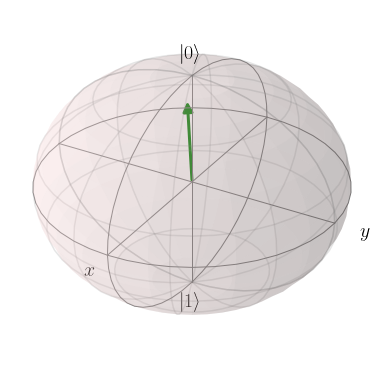

In [309]:
gain_amp = 1
loss_amp = 0.1

m = min(gain_amp, loss_amp)

ss = calculate_steady_state(gain_amp=gain_amp, loss_amp=loss_amp, signal_strength=0.2*m, detuning=0)

b = Bloch()
b.add_states(ss)
b.show()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.90801187 0.02967359]
 [0.02967359 0.09198813]]

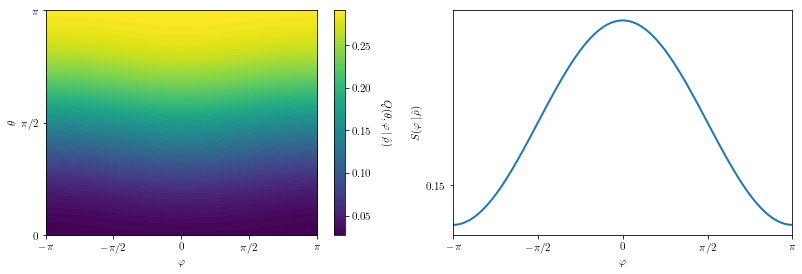

In [310]:
calc_and_plot_Q_and_S(ss)
ss

# Detuning $\times$ Phase $\times$ $S$

In [311]:
gain_amp=1
loss_amp=0.1

In [312]:
DR = 1
detunings = np.linspace(-DR, DR, n)

In [313]:

S = np.zeros([2*n, n])

for i, D in enumerate(detunings):
    state = calculate_steady_state(gain_amp=gain_amp, loss_amp=loss_amp, signal_strength=loss_amp, detuning=D)
    s = state.full()
    s[0,0], s[1,1] = s[1,1], s[0,0]
    s[0,1], s[1,0] = s[1,0], s[0,1]
    state = Qobj(s)
    Q = spin_husimi_qfunc(state, theta, phi)
    s = spin_S_measure(theta, Q)

    S[:, i] = s

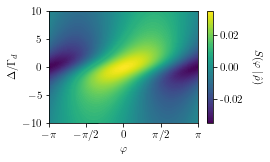

In [314]:
fig, ax = plt.subplots(figsize=set_size(DOCUMENT_WIDTH / 2))

DETUNING, PHI = np.meshgrid(detunings / loss_amp, phi)

cquad = ax.contourf(PHI, DETUNING, S, 100)
for c in cquad.collections:
    c.set_edgecolor("face")
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$\Delta/\Gamma_d$')

cbar = fig.colorbar(cquad)
cbar.set_label(r"$S(\varphi\,|\,\hat\rho)$", rotation=270, labelpad=20)
cbar.ax.yaxis.set_major_locator(MultipleLocator(base=0.02))
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.2f}"))
angle_xaxis(ax)

fig.savefig('results/csims/vary-detuning.pdf', bbox_inches="tight")

# Strength $\times$ Phase $\times$ $S$

In [315]:
gain_amp=1
loss_amp=0.1

In [316]:
ER = 0.1
strengths = np.linspace(0, ER, n)


In [317]:

S = np.zeros([2*n, n])

for i, E in enumerate(strengths):
    state = calculate_steady_state(gain_amp=gain_amp, loss_amp=loss_amp, signal_strength=E, detuning=0)
    s = state.full()
    s[0,0], s[1,1] = s[1,1], s[0,0]
    s[0,1], s[1,0] = s[1,0], s[0,1]
    state = Qobj(s)
    Q = spin_husimi_qfunc(state, theta, phi)
    s = spin_S_measure(theta, Q)

    S[:, i] = s

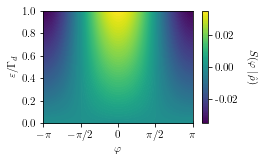

In [318]:
fig, ax = plt.subplots(figsize=set_size(DOCUMENT_WIDTH / 2))

STRENGTHS, PHI = np.meshgrid(strengths / loss_amp, phi)

cquad = ax.contourf(PHI, STRENGTHS, S, 100)
for c in cquad.collections:
    c.set_edgecolor("face")
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$\varepsilon/\Gamma_d$')

cbar = fig.colorbar(cquad)
cbar.set_label(r"$S(\varphi\,|\,\hat\rho)$", rotation=270, labelpad=20)
cbar.ax.yaxis.set_major_locator(MultipleLocator(base=0.02))
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.2f}"))
angle_xaxis(ax)

fig.savefig('results/csims/vary-strength.pdf', bbox_inches="tight")

# Strength $\times$ Detuning $\times$ $\max(S)$

In [319]:
gain_amp=1
loss_amp=0.1

In [320]:
n = 50

DR = 1
detunings = np.linspace(-DR, DR, 2*n)

ER = 0.1
strengths = np.linspace(0, ER, n)

In [321]:
Smax = np.zeros([2 * n, n])

for i, D in enumerate(detunings):
    for j, E in enumerate(strengths):
        state = calculate_steady_state(gain_amp=gain_amp, loss_amp=loss_amp, signal_strength=E, detuning=D)
        s = state.full()

        # Swap around dm parts to give correct orientation
        s[0, 0], s[1, 1] = s[1, 1], s[0, 0]
        s[0, 1], s[1, 0] = s[1, 0], s[0, 1]
        Q = spin_husimi_qfunc(state, theta, phi)
        s = spin_S_measure(theta, Q)

        Smax[i, j] = np.max(s)


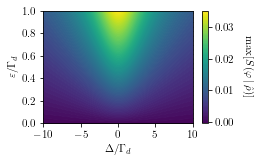

In [322]:
fig, ax = plt.subplots(figsize=set_size(DOCUMENT_WIDTH / 2))

DETUNINGS, STRENGTHS  = np.meshgrid(detunings / loss_amp, strengths / loss_amp)

cquad = ax.contourf(DETUNINGS, STRENGTHS, Smax.T, 100)
for c in cquad.collections:
    c.set_edgecolor("face")
ax.set_xlabel(r'$\Delta/\Gamma_d$')
ax.set_ylabel(r'$\varepsilon/\Gamma_d$')

cbar = fig.colorbar(cquad)
cbar.set_label(r"$\max[S(\varphi\,|\,\hat\rho)]$", rotation=270, labelpad=20)
cbar.ax.yaxis.set_major_locator(MultipleLocator(base=0.01))
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.2f}"))

fig.savefig('results/csims/arnold-tongue.pdf', bbox_inches="tight")